In [28]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import glob, time 

from astropy.io import fits as fits
from astropy.table import Table, vstack
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import healpy as hp
import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.targets import desi_mask, bgs_mask, mws_mask 
from desitarget.geomask import get_imaging_maskbits 

nside = 32
orig_density_per_deg = 2500 #random

#files
# all_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
main_survey_randoms = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits'

In [15]:
def bgs_mask(random):    
    is_bgs = random["BGS_TARGET"].data != 0

    print(np.mean(is_bgs))
    
    # random = random[is_bgs]

    # Apply custom imaging mask around bright stars etc.   
    bitnamelist = ["BRIGHT", "CLUSTER"] 

    bits = get_imaging_maskbits(bitnamelist) 

    print(bits)
    
    retain_random = np.ones(len(random['MASKBITS']), dtype=bool) #got rid of .data as didnt work below 

    for bit, ttype in zip(bits, bitnamelist): 
        # Keep random if bit not set for bits corresponding to BRIGHT and CLUSTER. 
        retain_random &= ((random['MASKBITS'] & 2**bit) == 0)  

        print(ttype, bit, np.mean(retain_random))

    #other cuts
    NOBS_mask = ((random['NOBS_G'] > 0) | (random['NOBS_R'] > 0) | (random['NOBS_Z'] > 0))
    
    retain_random = retain_random & NOBS_mask
 
    print('NOBS', np.mean(retain_random))

    return random[retain_random]

In [23]:
f = fits.open(main_survey_randoms)
random=f[1].data

In [24]:
# random = random[::500]

In [25]:
random=bgs_mask(random)

1.0
[1, 13]
BRIGHT 1 0.9905997485514495
CLUSTER 13 0.9904709859266433
NOBS 0.9771151783418405


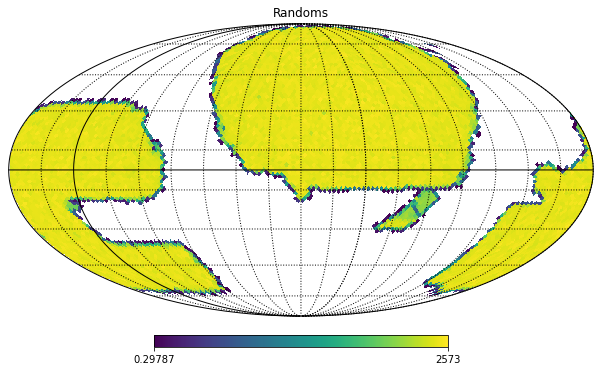

In [43]:
#ensure targets dont repeat
# need .data for astropy columns to arrays. 
#longitude = random['RA']
#latitude = random['DEC']
unique_target_list = random['TARGETID']

#number of pixels on sphere and pixel area
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

theta = np.pi / 2. - np.radians(random['DEC'].data)
phi = np.radians(random['RA'].data)

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel/pixel_area
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#mollview map of pixels
hp.mollview(targets_per_pixel,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='Randoms')
hp.graticule(dpar=5, dmer=5) 
    
#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area * orig_density_per_deg
filling_factor = targets_per_pixel/exp_density_per_pixel
corr_pixel_area = pixel_area * filling_factor      

Text(0.5, 0, 'Random filling factor')

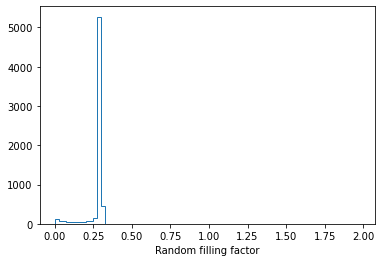

In [44]:
_ = plt.hist(filling_factor, bins=np.arange(0.0, 2.0, 0.025), histtype='step')
plt.xlabel('Random filling factor')

In [48]:
# to_grab will be a list of file paths for files in the directory provided.  	 
#to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv3/bright/sv3mtl-bright-hp-*.ecsv') 
to_grab=glob.glob('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/main/bright/mtl-bright-hp-*.ecsv') 

# very good practice to apply sorted, otherwise the file ordering will be random 	and non-repeatable.  
to_grab = sorted(to_grab) 

hp_stack = []

start = time.time() 

npix_todo = 14000

mmask = 'BGS_TARGET'
ttype = 'BGS_BRIGHT'

for i, x in enumerate(to_grab):
    x = pd.read_csv(x, comment='#', delimiter='\s+', usecols=['RA', 'DEC', 'TARGETID', 'BGS_TARGET', 'MWS_TARGET'])

    is_main_blue = (x[mmask] & bgs_mask[ttype]) != 0

    idx = np.arange(len(x))[is_main_blue]
    
    x = x.iloc[idx] 
    
    hp_stack.append(x)

    if (i % 100) == 0:
        runtime = (time.time() - start)

        print('Runtime of {:.6f} seconds after {:d} pixels'.format(runtime, i))

    if i > npix_todo:
        break
        
# Create a big table from the list of tables.  
# data_stack = vstack(hp_stack) 

data_stack = pd.concat(hp_stack, ignore_index=True)

mask,idx = np.unique(data_stack['TARGETID'],return_index=True)
data_stack = data_stack.iloc[idx]

data_stack = Table.from_pandas(data_stack)

runtime = (time.time() - start)

print('\n\nTotal runtime of {:.6f} seconds after {:d} pixels'.format(runtime, npix_todo))

data_stack

Runtime of 0.038625 seconds after 0 pixels
Runtime of 3.631031 seconds after 100 pixels
Runtime of 9.988091 seconds after 200 pixels
Runtime of 15.531003 seconds after 300 pixels
Runtime of 23.701752 seconds after 400 pixels
Runtime of 30.849328 seconds after 500 pixels
Runtime of 37.098508 seconds after 600 pixels
Runtime of 43.744839 seconds after 700 pixels
Runtime of 50.968780 seconds after 800 pixels
Runtime of 56.067711 seconds after 900 pixels
Runtime of 60.905777 seconds after 1000 pixels
Runtime of 65.853304 seconds after 1100 pixels
Runtime of 73.962280 seconds after 1200 pixels
Runtime of 82.274590 seconds after 1300 pixels
Runtime of 91.258531 seconds after 1400 pixels
Runtime of 97.054779 seconds after 1500 pixels
Runtime of 103.414422 seconds after 1600 pixels
Runtime of 109.528318 seconds after 1700 pixels
Runtime of 115.891794 seconds after 1800 pixels
Runtime of 121.623485 seconds after 1900 pixels
Runtime of 128.689717 seconds after 2000 pixels
Runtime of 135.593804 s

RA,DEC,TARGETID,BGS_TARGET,MWS_TARGET
float64,float64,int64,int64,int64
59.60086559409994,-68.12683131313392,39626498281308189,131074,0
60.00983139575825,-68.16966639837612,39626498281308607,131074,0
60.01124019929327,-68.16379040745758,39626498281308610,131074,0
60.067316634746724,-68.1403940503445,39626498281308675,131074,0
60.27687723658043,-68.1477166136955,39626498285502547,131074,0
60.351730827700045,-68.1384524183673,39626498285502613,131074,0
60.35480903565853,-68.15736062454609,39626498285502619,131074,0
60.41502834204189,-68.14758441322456,39626498285502711,131074,0
60.57191230896668,-68.15293728255374,39626498285502939,131074,0


In [49]:
theta = np.pi / 2. - np.radians(data_stack['DEC'].data)
phi = np.radians(data_stack['RA'].data)

In [50]:
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#update no. targets per pixel 
#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

targets_per_pixel[(filling_factor < 0.2)] = np.NaN 

targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
targets_per_pixel[targets_per_pixel == 0] = np.NaN 
target_density= targets_per_pixel/pixel_area

In [51]:
len(targets_per_pixel), len(filling_factor)

(12288, 12288)

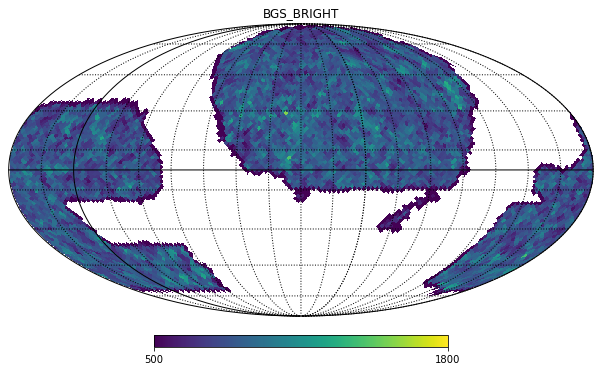

In [52]:
#mollview map of pixels
hp.mollview(target_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title=ttype, min=500., max=1800.)
hp.graticule(dpar=5, dmer=5) 